In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
df = pd.read_csv('blogtext.csv', parse_dates = ['date']).sample(10000)

In [2]:
df = df[df['topic']!='indUnk']
df = df[df['topic']!='Student'].copy()
df.reset_index(drop=True, inplace=True)
df.head()

,id,gender,age,topic,sign,date,text
0,4017562,female,14,Arts,Virgo,"10,August,2004",Fuck you. Thats all I have...
1,589736,male,35,Technology,Aries,"05,August,2004","umm, yel, that's me mir not jls. ..."
2,3676452,male,37,Marketing,Gemini,"11,August,2004",This is an old news item from AP bu...
3,871501,female,27,Marketing,Gemini,"24,January,2004",Hi! I will post more very soon...l...
4,2861748,female,27,Education,Cancer,"09,May,2004",I write to get these Sylvia P...


In [3]:
import spacy
import re
nlp = spacy.load('en_core_web_sm')

#Creating the tokens, which are an important spaCy datatype.
df['tokens'] = df['text'].apply(lambda x: nlp.tokenizer(x.lower()))
spacy_stopwords = [spacy.lang.en.stop_words.STOP_WORDS] + ['urllink']

#Turning the tokens to Python datatypes and cleaning, for non-spaCy work.
def clean(lst):
#     lst = [token for token in lst if not token.is_stop]
    lst = [token.lemma_ for token in lst if not token.is_stop]
#     lst.remove('urllink') if 'urllink' in lst else lst
#     lst.remove('nbsp') if 'nbsp' in lst else lst
    lst = [l.replace('nbsp', '').replace('urllink', '') for l in lst]
    lst = [re.sub(r'[\W]', '', string) for string in lst]
    while '' in lst:
        lst.remove('')
    return lst
df['formatted'] = df['tokens'].map(lambda x: clean(x))

#Creating a single-string version of the cleaned texts, for tools that require it.
df['form_str'] = df['formatted'].map(lambda x: ' '.join(x))
df['formatted'].head()

0    [fuck, s, right, o, asshole, walk, family, lik...
1                                 [umm, yel, mir, jls]
2    [old, news, item, ap, come, time, pass, syracu...
3    [hello, post, soon, like, late, tonight, want,...
4    [write, sylvia, plath, ghost, head, write, pro...
Name: formatted, dtype: object

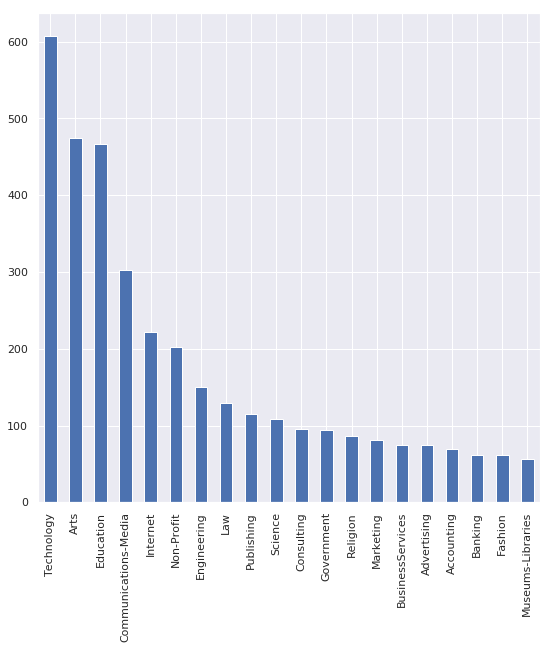

In [4]:
#Removing all classes but the 20 most populous.
most_pop = list(df.groupby('topic')['topic'].agg('count').sort_values(ascending=False)[:20].index)
df = df[df['topic'].isin(most_pop)]
plt.figure(figsize=(9,9))
df['topic'].value_counts().plot('bar')
#So we have imbalanced classes, but not so much that we can't manage it.
#A lot of these classes are super similar. I might need to combine them.

In [5]:
tech = df[df['topic']=='Internet']
tech.head(10)['form_str']

6      word happy snow decide get bus dignity aside y...
35                      mike quando la trovi una ragazza
50     hamiltons o fun good time hamilton drink ticke...
81     truly dramatic music death life outstanding co...
87     eternal life jeff buckley eternal life trail g...
115    yep planet common dirt need prove presence lif...
118    byrning house bummer want tape tonight vcr wor...
137    college learn big word talk real loud goddamn ...
138    late get roughly 6 hour sleep night bed instea...
150                                                     
Name: form_str, dtype: object

# Machine Learning Pre-Processing

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y=le.fit_transform(df['topic'])
X = df['form_str']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
#Metrics I'm going to use
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, classification_report

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=.01)
clf = clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.54      0.35      0.42        20
           1       0.00      0.00      0.00        16
           2       0.22      0.54      0.31       112
           3       0.20      0.06      0.09        17
           4       0.17      0.05      0.08        20
           5       0.18      0.17      0.17        75
           6       0.00      0.00      0.00        24
           7       0.19      0.25      0.22       123
           8       0.08      0.02      0.04        45
           9       0.10      0.07      0.08        15
          10       0.00      0.00      0.00        25
          11       0.13      0.08      0.10        53
          12       0.00      0.00      0.00        40
          13       0.00      0.00      0.00        21
          14       0.50      0.33      0.40         6
          15       0.20      0.10      0.13        50
          16       0.00      0.00      0.00        31
          17       0.23    

In [8]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf=clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
accuracy_score(y_test, y_preds)

0.17194570135746606

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
accuracy_score(y_test, y_preds)

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.1436651583710407

In [10]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf = clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
accuracy_score(y_test, y_preds)

0.19343891402714933